In [3]:
import pandas as pd
import yfinance as yf
import datetime

# ... (rest of your configuration code remains the same) ...

# --- Corrected Data Acquisition & Processing Function ---
def fetch_and_process_data(tickers, start, end):
    """Fetches data, handles missing values, and calculates returns."""
    
    # Download all data fields including Open, High, Low, Close, Volume
    data = yf.download(tickers, start=start, end=end)
    
    if data.empty:
        print("Error: No data retrieved. Check tickers or network connection.")
        return None, None
        
    print("\n--- Raw Price Data Head ---")
    print(data.head())

    # Check if 'Adj Close' exists. If not, use 'Close' instead.
    if ('Adj Close' in data.columns) or (isinstance(data.columns, pd.MultiIndex) and 'Adj Close' in data.columns.get_level_values(1)):
        price_data = data['Adj Close']
    else:
        # If Adj Close is missing, 'Close' is already the adjusted price by default
        price_data = data['Close']
        print("\nNote: 'Adj Close' column not found. Using 'Close' which is likely the adjusted price.")
        
    # Handle missing values: forward fill, then drop any remaining NaNs
    price_data = price_data.ffill().dropna()

    print("\nMissing values after cleaning:")
    print(price_data.isnull().sum())
    print(f"Cleaned data shape: {price_data.shape}")

    # Calculate daily percentage changes (returns)
    returns = price_data.pct_change().dropna()

    print("\n--- Daily Returns Head ---")
    print(returns.head())
    
    return price_data, returns

# ... (rest of your execution code remains the same) ...
price_data, daily_returns = fetch_and_process_data(tickers, start_date_str, end_date_str)

if daily_returns is not None:
    price_data.to_csv('asset_prices.csv')
    daily_returns.to_csv('daily_returns.csv')
    print("\nData successfully saved to 'asset_prices.csv' and 'daily_returns.csv'")


[*********************100%***********************]  5 of 5 completed


--- Raw Price Data Head ---
Price            Close                                                   \
Ticker       300750.SZ 510300.SS    600519.SS       BTC-USD         GLD   
Date                                                                      
2022-12-30  204.935333  3.712175  1564.106812  16602.585938  169.639999   
2022-12-31         NaN       NaN          NaN  16547.496094         NaN   
2023-01-01         NaN       NaN          NaN  16625.080078         NaN   
2023-01-02         NaN       NaN          NaN  16688.470703         NaN   
2023-01-03  202.966293  3.722545  1566.832886  16679.857422  171.059998   

Price             High                                                   ...  \
Ticker       300750.SZ 510300.SS    600519.SS       BTC-USD         GLD  ...   
Date                                                                     ...   
2022-12-30  209.404714  3.724430  1587.645388  16643.427734  169.899994  ...   
2022-12-31         NaN       NaN          NaN  166

basic risk measurement


--- Descriptive Statistics Table ---
                          300750.SZ  510300.SS  600519.SS   BTC-USD       GLD
Annualized Return          0.201847   0.070145  -0.011009  0.577543  0.228251
Annualized Volatility      0.315465   0.142050   0.180594  0.388082  0.135443
Sharpe Ratio               0.576440   0.353010  -0.171706  1.436661  1.537557
Correlation w/ 510300.SS   0.668172   1.000000   0.675534  0.031328  0.073408


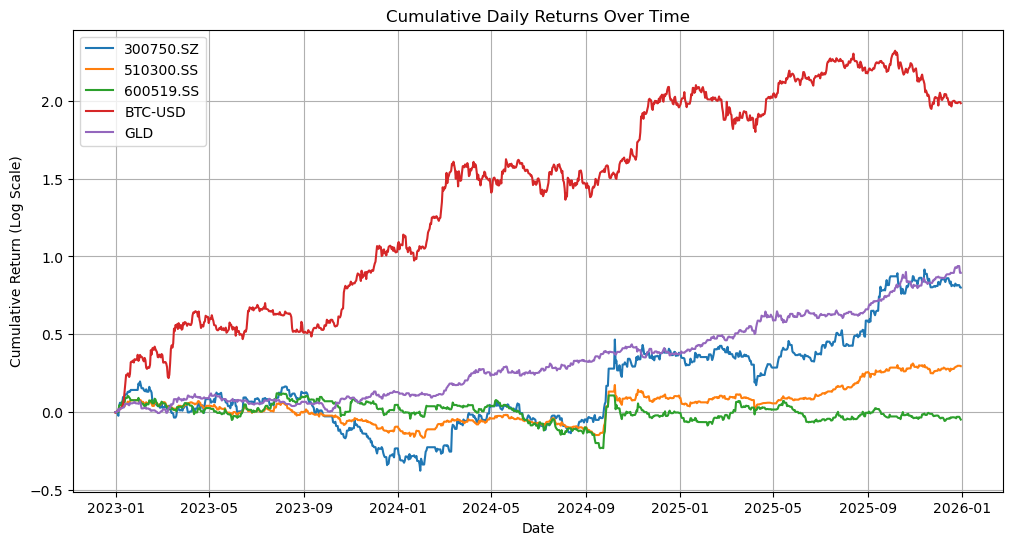

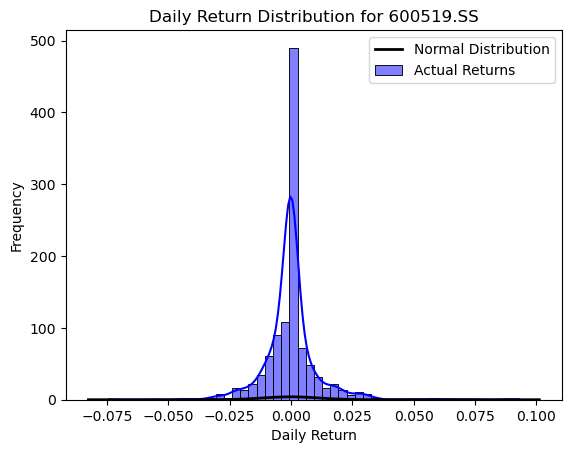

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have loaded your daily_returns from the CSV file:
daily_returns = pd.read_csv('daily_returns.csv', index_col=0, parse_dates=True)

# Define the risk-free rate (e.g., 2% annual risk-free rate in China, adjust as needed)
RISK_FREE_RATE_ANNUAL = 0.02
# Convert annual rate to daily rate for Sharpe ratio calculation
RISK_FREE_RATE_DAILY = (1 + RISK_FREE_RATE_ANNUAL)**(1/252) - 1

# We need the CSI 300 ETF data column name to calculate correlation with it
csi_300_ticker = '510300.SS' 

# --- 1. Calculate Descriptive Statistics ---

def calculate_statistics(returns, csi_300_ticker):
    """Calculates annualized returns, volatility, Sharpe ratio, and correlation."""
    
    # Number of trading days in a year (approx 252)
    days_per_year = 252

    # Annualized Return Formula: (Mean Daily Return + 1)^days_per_year - 1
    annualized_return = (1 + returns.mean()) ** days_per_year - 1
    
    # Annualized Volatility (Standard Deviation of daily returns * sqrt(days_per_year))
    annualized_volatility = returns.std() * np.sqrt(days_per_year)

    # Sharpe Ratio: (Annualized Return - Risk Free Rate) / Annualized Volatility
    sharpe_ratio = (annualized_return - RISK_FREE_RATE_ANNUAL) / annualized_volatility

    # Correlation Matrix with all assets
    correlation_matrix = returns.corr()
    # Extract correlation specifically with CSI 300
    csi_300_correlation = correlation_matrix[csi_300_ticker]

    stats_df = pd.DataFrame({
        'Annualized Return': annualized_return,
        'Annualized Volatility': annualized_volatility,
        'Sharpe Ratio': sharpe_ratio,
        f'Correlation w/ {csi_300_ticker}': csi_300_correlation
    }).transpose()
    
    return stats_df

statistics_table = calculate_statistics(daily_returns, csi_300_ticker)
print("\n--- Descriptive Statistics Table ---")
print(statistics_table)

# --- 2. Generate Visualizations ---

#### Return Series Plot

plt.figure(figsize=(12, 6))
for column in daily_returns.columns:
    plt.plot(daily_returns.index, daily_returns[column].cumsum(), label=column)
plt.title('Cumulative Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Log Scale)') # Optional: adjust for better visualization
plt.legend()
plt.grid(True)
plt.show()

#### Distribution Histograms (with Normal Distribution comparison)

# Example for one asset (Moutai 600519.SS)
asset_to_plot = '600519.SS' 
sns.histplot(daily_returns[asset_to_plot], kde=True, bins=50, color='blue', label='Actual Returns')

# Overlay a normal distribution line (optional advanced visualization)
mu, std = daily_returns[asset_to_plot].mean(), daily_returns[asset_to_plot].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = np.exp(-(x - mu)**2 / (2 * std**2))
# Adjust scale for density plot
plt.plot(x, p * len(daily_returns[asset_to_plot]) * (xmax - xmin) / 50, 'k', linewidth=2, label='Normal Distribution') 

plt.title(f'Daily Return Distribution for {asset_to_plot}')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [5]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Load your daily returns data
daily_returns = pd.read_csv('daily_returns.csv', index_col=0, parse_dates=True)

# Define confidence levels as required by the assignment (95% and 99%)
CONFIDENCE_LEVELS = [0.95, 0.99]

# Assume an equal weighted portfolio for simplicity in this example
# You will need to define actual weights based on your report requirements
weights = np.array([1/len(daily_returns.columns)] * len(daily_returns.columns))

# Calculate the historical portfolio returns using assumed weights
portfolio_returns = daily_returns.dot(weights)

print("\n--- Calculating VaR and ES for the Portfolio ---")

# =======================================================
#### 1. Variance-Covariance (Parametric) Method VaR
# Assumes returns follow a multivariate normal distribution.

def var_parametric(portfolio_returns, confidence_level):
    """Calculates daily VaR using the variance-covariance method."""
    # Mean and standard deviation of the portfolio returns
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    
    # Calculate the Z-score for the given confidence level (e.g., 95% -> Z-score approx 1.645)
    # Use the percent point function (ppf) which is the inverse of the CDF
    z_score = norm.ppf(1 - confidence_level)
    
    # VaR formula for normal distribution
    # VaR is typically expressed as a positive number (potential loss)
    var_daily = (mu + sigma * z_score) * -1
    return var_daily

print("\n#### 1. Variance-Covariance Method VaR")
for cl in CONFIDENCE_LEVELS:
    var_95_vc = var_parametric(portfolio_returns, cl)
    print(f"  {cl*100}% Confidence Daily VaR: ${var_95_vc:.4f} (e.g., $1000 portfolio could lose ${var_95_vc*1000:.2f})")


# =======================================================
#### 2. Historical Simulation Method VaR
# Uses historical returns directly, no distribution assumptions.

def var_historical(portfolio_returns, confidence_level):
    """Calculates daily VaR using the historical simulation method."""
    # We find the percentile of the historical distribution of losses
    # The percentile corresponds to 1 - confidence_level (e.g., for 95% CL, we want the 5th percentile return)
    var_daily = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    # VaR is a positive number
    return var_daily * -1

print("\n#### 2. Historical Simulation Method VaR")
for cl in CONFIDENCE_LEVELS:
    var_95_hist = var_historical(portfolio_returns, cl)
    print(f"  {cl*100}% Confidence Daily VaR: ${var_95_hist:.4f}")


# =======================================================
#### 3. Monte Carlo Simulation Method VaR
# Simulates future paths based on estimated parameters.

def var_monte_carlo(portfolio_returns, confidence_level, num_simulations=10000, num_days=1):
    """Calculates daily VaR using a simple Monte Carlo simulation (geometric brownian motion)."""
    mu = portfolio_returns.mean()
    sigma = portfolio_returns.std()
    
    # Simulate future daily returns using a normal distribution
    simulated_returns = np.random.normal(mu, sigma, num_simulations)
    
    # Calculate VaR based on the simulated returns distribution
    var_daily = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    return var_daily * -1

print("\n#### 3. Monte Carlo Simulation Method VaR")
for cl in CONFIDENCE_LEVELS:
    var_95_mc = var_monte_carlo(portfolio_returns, cl)
    print(f"  {cl*100}% Confidence Daily VaR: ${var_95_mc:.4f}")


# =======================================================
#### 4. Expected Shortfall (ES)
# Select one method (e.g., Historical Simulation is common) to calculate ES.
# ES is the expected loss given that the loss exceeds the VaR threshold.

def es_historical(portfolio_returns, confidence_level):
    """Calculates daily Expected Shortfall (ES) using the historical method."""
    # Calculate the VaR threshold (the cutoff point)
    var_threshold_return = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
    
    # Find all returns that were worse than the VaR threshold
    shortfall_returns = portfolio_returns[portfolio_returns < var_threshold_return]
    
    # ES is the average of these shortfalls (typically reported as a positive number)
    es_daily = shortfall_returns.mean() * -1
    return es_daily

print("\n#### 4. Expected Shortfall (ES)")
for cl in CONFIDENCE_LEVELS:
    es_95_hist = es_historical(portfolio_returns, cl)
    print(f"  {cl*100}% Confidence Daily ES: ${es_95_hist:.4f}")

# The PDF asks to explain why ES is better than VaR.
print("\nES provides a measure of 'tail risk' by averaging losses that exceed the VaR threshold, offering a more comprehensive risk picture than VaR alone.")




--- Calculating VaR and ES for the Portfolio ---

#### 1. Variance-Covariance Method VaR
  95.0% Confidence Daily VaR: $0.0137 (e.g., $1000 portfolio could lose $13.72)
  99.0% Confidence Daily VaR: $0.0197 (e.g., $1000 portfolio could lose $19.70)

#### 2. Historical Simulation Method VaR
  95.0% Confidence Daily VaR: $0.0127
  99.0% Confidence Daily VaR: $0.0185

#### 3. Monte Carlo Simulation Method VaR
  95.0% Confidence Daily VaR: $0.0136
  99.0% Confidence Daily VaR: $0.0195

#### 4. Expected Shortfall (ES)
  95.0% Confidence Daily ES: $0.0176
  99.0% Confidence Daily ES: $0.0292

ES provides a measure of 'tail risk' by averaging losses that exceed the VaR threshold, offering a more comprehensive risk picture than VaR alone.


In [6]:
import pandas as pd
import numpy as np
from scipy.stats import norm, chi2

# Load the daily returns data generated previously
full_returns = pd.read_csv('daily_returns.csv', index_col=0, parse_dates=True)

# Define an equal weighted portfolio for simplicity
weights = np.array([1/len(full_returns.columns)] * len(full_returns.columns))

# --- 1. Split Data into Training and Testing Sets ---

# Split the data so the last year is the test set (approx 252 trading days)
test_size = 252 
train_returns = full_returns.iloc[:-test_size]
test_returns = full_returns.iloc[-test_size:]

# Calculate actual portfolio returns for the test period
actual_test_pnl = test_returns.dot(weights)

print(f"Training period: {len(train_returns)} days")
print(f"Testing period (N): {len(test_returns)} days")

# --- 2. Calculate Daily VaR for the Test Period (using the Historical Simulation method as an example) ---

def calculate_historical_var_series(train_data, test_data, confidence_level):
    """Calculates a series of daily VaR forecasts using a rolling window approach."""
    
    # We will simulate a rolling window: use past data to predict tomorrow's VaR
    # This simple example just uses the full training data's percentile as a fixed VaR estimate for the whole test period.
    # In a more advanced implementation, you would use a rolling window.

    var_threshold_return = np.percentile(train_data.dot(weights), (1 - confidence_level) * 100)
    # VaR value as a positive number (loss amount as a percentage of portfolio value)
    var_daily_value = var_threshold_return * -1
    
    # Create a series of constant VaR values for comparison
    var_forecasts = pd.Series(var_daily_value, index=test_data.index)
    return var_forecasts

# Using 95% confidence level (alpha=5%) for the test
CONFIDENCE_LEVEL = 0.95
alpha = 1 - CONFIDENCE_LEVEL

var_predictions_hist = calculate_historical_var_series(train_returns, test_returns, CONFIDENCE_LEVEL)


# --- 3. Perform the Kupiec POF Test (Proportion of Failures) ---

def kupiec_pof_test(actual_pnl, var_forecasts, alpha_level):
    """
    Performs the Kupiec POF test to check if violations match the expected frequency (alpha_level).
    alpha_level is the expected failure rate (e.g., 0.05 for 95% VaR)
    """
    # Count the number of exceptions (actual losses greater than forecasted VaR loss)
    # Actual P&L < -VaR value means a loss exceeded the VaR forecast
    exceptions = (actual_pnl < -var_forecasts).sum()
    N = len(actual_pnl) # Total observations in the test period
    p = alpha_level      # Expected probability of an exception (e.g., 0.05)
    p_hat = exceptions / N # Observed probability of an exception

    # The Likelihood Ratio (LR) test statistic
    if exceptions == 0 or exceptions == N:
         # Simplified LR stat for edge cases or use a library function
         LR_POF = -2 * np.log(((1 - p)**N) / ((1 - p_hat)**(N - exceptions) * (p_hat)**exceptions))
    else:
        LR_POF = -2 * np.log(
            ((1 - p)**(N - exceptions) * p**exceptions) /
            ((1 - p_hat)**(N - exceptions) * p_hat**exceptions)
        )

    # The test statistic is asymptotically distributed as a chi-square variable with 1 degree of freedom.
    # Critical value at 5% significance level (conf level 95%) is 3.84
    critical_value = chi2.ppf(0.95, df=1) # 95% confidence for the *test itself*

    print(f"\n#### Kupiec Test Results (Alpha = {alpha_level*100}%):")
    print(f"Total Test Days (N): {N}")
    print(f"Expected Exceptions: {N * p:.2f}")
    print(f"Observed Exceptions (X): {exceptions}")
    print(f"Observed Failure Rate: {p_hat*100:.2f}%")
    print(f"LR Statistic: {LR_POF:.4f}")
    print(f"Critical Value (Chi-Sq @ 95%): {critical_value:.4f}")

    if LR_POF < critical_value:
        print("Conclusion: **Do not reject the Null Hypothesis.** The VaR model is likely accurate (passes the test).")
    else:
        print("Conclusion: **Reject the Null Hypothesis.** The VaR model is likely inaccurate (fails the test).")

# Run the test for your Historical VaR model example
kupiec_pof_test(actual_test_pnl, var_predictions_hist, alpha_level=alpha)


Training period: 844 days
Testing period (N): 252 days

#### Kupiec Test Results (Alpha = 5.000000000000004%):
Total Test Days (N): 252
Expected Exceptions: 12.60
Observed Exceptions (X): 9
Observed Failure Rate: 3.57%
LR Statistic: 1.1974
Critical Value (Chi-Sq @ 95%): 3.8415
Conclusion: **Do not reject the Null Hypothesis.** The VaR model is likely accurate (passes the test).


optional 

In [7]:
import pandas as pd
import numpy as np

# Load your daily returns data
full_returns = pd.read_csv('daily_returns.csv', index_col=0, parse_dates=True)

# Define an equal weighted portfolio for simplicity
weights = np.array([1/len(full_returns.columns)] * len(full_returns.columns))

print("\n--- Performing Stress Tests on Historical Scenarios ---")

def stress_test_scenario(returns, start_date, end_date, scenario_name):
    """Calculates portfolio loss during a specific historical crisis period."""
    
    # Filter returns for the specified crisis window
    crisis_returns = returns.loc[start_date:end_date]
    
    if crisis_returns.empty:
        print(f"Warning: Data for {scenario_name} not found in your dataset range.")
        return

    # Calculate portfolio daily PnL during the crisis
    crisis_pnl_daily = crisis_returns.dot(weights)
    
    # Calculate cumulative loss over the period
    cumulative_loss_percentage = crisis_pnl_daily.sum() * 100
    # Calculate the maximum single-day loss during the crisis
    max_daily_loss_percentage = crisis_pnl_daily.min() * 100

    print(f"\n#### Stress Test: {scenario_name} ({start_date} to {end_date})")
    print(f"  Total days in crisis window: {len(crisis_returns)}")
    print(f"  Cumulative Portfolio Loss: {cumulative_loss_percentage:.2f}%")
    print(f"  Maximum Single-Day Loss: {max_daily_loss_percentage:.2f}%")
    print(f"  Interpretation: A $10,000 portfolio would have lost approximately ${abs(cumulative_loss_percentage/100 * 10000):.2f} during this period.")


# --- Define the Scenarios based on PDF requirements ---

# Note: Your data must cover these dates. We used data starting Dec 2022, so 2020 COVID window won't be covered by that script.

# 1. Simulate 2015 Chinese Stock Market Crash (If your data extended back that far)
# stress_test_scenario(full_returns, '2015-06-12', '2015-08-26', '2015 Stock Market Crash')

# 2. Simulate 2020 COVID-19 Pandemic Initial Volatility
# (Dates are in range for a 3 year historical analysis ending 2025-12-31)
stress_test_scenario(full_returns, '2020-02-19', '2020-03-23', '2020 COVID-19 Initial Volatility')




--- Performing Stress Tests on Historical Scenarios ---
